### General Runge-Kutta Method & Butcher Table
\begin{equation}
    y_{i+1}=y_i+\Delta t\sum_{i=1}^na_ik_i+O(\Delta t^{n+1})
\end{equation}
\begin{align*}
    k_1&=f(t_i,y_i)\\
    k_2&=f(t_i+p_2\Delta t,y_i+\Delta t(q_{21}k_1))\\
    k_3&=f(t_i+p_3\Delta t,y_i+\Delta t(q_{31}k_1+q_{32}k_2))\\
    \vdots\\
    k_n&=f(t_i+p_n\Delta t,y_i+\Delta t(q_{n1}k_1+q_{n2}k_2+\ldots+q_{n,n-1}k_{n-1}))
\end{align*}
<img src="images/butcher_table.png" width="362" height="237" align="center"/>

In [1]:
function RK2(t::Real, y::Vector{<:Real}, f::Function, h::Real, args...)
    # Heun's Method
    # p = [0, 1]
    # q = [0 0; 1 0]
    # a = [1/2, 1/2]
    
    # Ralston's Method
    p = [0, 2/3]
    q = [0 0; 2/3 0]
    a = [1/4; 3/4]
    
    k1 = f(t, y, args...)
    k2 = f(t + p[2]*h, y + h*(q[2, 1]*k1), args...)
    return y + h*(a[1]*k1 + a[2]*k2)
end

function RK4(t::Real, y::Vector{<:Real}, df::Function, h::Real, args...)
    p = [0, 1/2, 1/2, 1]
    q = [0 0 0 0; 1/2 0 0 0; 0 1/2 0 0; 0 0 1 0]
    a = [1/6, 1/3, 1/3, 1/6]
    
    k1 = f(t, y, args...)
    k2 = f(t + p[2]*h, y + h*(q[2, 1]*k1), args...)
    k3 = f(t + p[3]*h, y + h*(q[3, 1]*k1 + q[3, 2]*k2), args...)
    k4 = f(t + p[4]*h, y + h*(q[4, 1]*k1 + q[4, 2]*k2 + q[4, 3]*k3), args...)
    return y + h*(a[1]*k1 + a[2]*k2 + a[3]*k3 + a[4]*k4)
end;

In [2]:
function odeint(f::Function, tspan::NTuple{2, Real}, y0::Vector{<:Real}, 
        h::Real, args...; method::Symbol=:RK4)
    t = collect(tspan[1]:h:tspan[2])
    y = zeros(length(y0), length(t))
    y[:, 1] = y0 # Initial Condition
    RK = method ∈ (:RK2, :RK4) ? eval(method) : 
        error("Invalid Runge-Kutta Method")
    for i = 1:(length(t) - 1)
        y[:, i + 1] = RK(t[i], y[:, i], f, h, args...)
    end
    return t, y
end;

In [3]:
function downsize(u0::Vector{<:Real}, N::Int=1)
    size::Int = (length(u0) - 1)/2 + 1
    u = [u0[2i - 1] for i = 1:size] 
    return N == 1 ? u : downsize(u, N - 1)
end

function convergence(u::NTuple{3, Vector{<:Real}})
    u_D1 = downsize(u[2])
    u_D2 = downsize(u[3], 2)
    return log2.(abs.((u[1] - u_D1)./(u_D1 - u_D2)))
end;

#### Initial Value Problem:
$$y'' + y' + 2y = 0,\,0\leq t\leq 25$$
$$y(0) = 1,\,y'(0) = 0$$

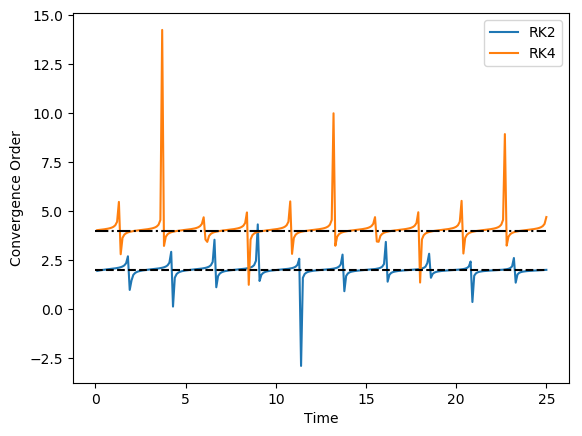

In [4]:
using PyPlot

f(t, x) = [x[2], -2 * x[1] - x[2]]

t1, y1 = odeint(f, (0, 25), [1, 0], 0.1, method=:RK2)
t2, y2 = odeint(f, (0, 25), [1, 0], 0.1/2, method=:RK2)
t3, y3 = odeint(f, (0, 25), [1, 0], 0.1/4, method=:RK2)
plot(t1, convergence((y1[1, :], y2[1, :], y3[1, :])), label="RK2")

t1, y1 = odeint(f, (0, 25), [1, 0], 0.1, method=:RK4)
t2, y2 = odeint(f, (0, 25), [1, 0], 0.1/2, method=:RK4)
t3, y3 = odeint(f, (0, 25), [1, 0], 0.1/4, method=:RK4)
plot(t1, convergence((y1[1, :], y2[1, :], y3[1, :])), label="RK4")

plot(t1, fill(2.0, length(t1)), "k--")
plot(t1, fill(4.0, length(t1)), "k-.")
plt.ylabel("Convergence Order"); plt.xlabel("Time"); plt.legend();